# Solving the PDE $\partial_t u - \Delta u = f$ with discontinuous Galerkin in time and continuous Galerkin in space in FEniCS by exploiting the kronecker product structure of the space-time matrix

In [1]:
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

Using discontinuous finite elements in time and continuous finite elements in space, the variational formulation for the PDE reads
$$
\int_0^T (\partial_t u, \phi) - (\nabla u, \nabla \phi)\ \mathrm{d}t + \sum_{m = 1}^{M-1} ([u]_m, \phi_m^+) + (u_0^+, \phi_0^+) = (u^0, \phi_0^+).
$$
Here the jump $[u]_m$ is defined as $[u]_m = u_m^+ - u_m^-$, where $u_m^+$ is the limit from above and $u_m^-$ is the limit from below at $t_m$.
The second term with the jump terms can be thought of as the integral/sum over the interior faces, since we have the temporal elements $(t_0, t_1), (t_1, t_2), ..., (t_{M-1}, t_M)$. Furthermore, we denote by the inner product $(f,g)$, the $L^2(\Omega)$ inner product, i.e.
$$
(f,g) := (f,g)_{L^2(\Omega)} := \int_\Omega f \cdot g\ \mathrm{d}x.
$$
NOTE: An explanation of this code can be found in Homework 3 of the Space-Time FEM Lecture at the Leibniz Univeristy Hannover in the winter semester 2023.

In [12]:
from fenics import *
import matplotlib.pyplot as plt
import numpy as np
import scipy
import time

set_log_active(False)
parameters["reorder_dofs_serial"] = False

def cartesian_product_coords(time_coords, space_coords):
    long_time_coords = np.kron(time_coords, np.ones((space_coords.shape[0],1)))
    long_space_coords = np.kron(np.ones((time_coords.shape[0],1)), space_coords)
    return np.hstack((long_time_coords, long_space_coords))

In [21]:
class SpaceFE:
    form = {}
    matrix = {}

    def __init__(self, mesh, V):
        self.mesh = mesh
        self.V = V
        self.dofs = self.V.tabulate_dof_coordinates().reshape((-1, mesh.geometry().dim()))
        self.n_dofs = self.dofs.shape[0]
        # For debugging:
        # self.print_dofs()
        self.assemble_matrices()

    def print_dofs(self):
        print("\nSpace DoFs:")
        for dof, dof_x in zip(self.V.dofmap().dofs(), self.dofs):
            print(dof, ':', dof_x)

    def assemble_matrices(self):
        u = TrialFunction(self.V)
        phi = TestFunction(self.V)

        self.form["laplace"] = inner(grad(u), grad(phi))*dx
        self.form["mass"] = u*phi*dx

        for (name, _form) in self.form.items():
            self.matrix[name] = scipy.sparse.csr_matrix(
                as_backend_type(assemble(_form)).mat().getValuesCSR()[::-1],
                shape=(self.n_dofs, self.n_dofs)
            )
            
class TimeFE:
    form = {}
    matrix = {}

    def __init__(self, mesh, V):
        self.mesh = mesh
        self.V = V
        self.dofs = self.V.tabulate_dof_coordinates().reshape((-1, 1))
        self.n_dofs = self.dofs.shape[0]
        # For debugging:
        self.print_dofs()
        self.assemble_matrices()

    def print_dofs(self):
        print("\nTime DoFs:")
        for dof, dof_t in zip(self.V.dofmap().dofs(), self.dofs):
            print(dof, ':', dof_t)

    def assemble_matrices(self):
        initial_time = CompiledSubDomain('near(x[0], t0)', t0=self.dofs[0,0])
        interior_facets = CompiledSubDomain("!on_boundary")
        boundary_marker = MeshFunction("size_t", self.mesh, 0)
        boundary_marker.set_all(0)
        initial_time.mark(boundary_marker, 1)
        interior_facets.mark(boundary_marker, 2)

        # Measure for the initial time
        d0 = Measure('ds', domain=self.mesh, subdomain_data=boundary_marker, subdomain_id=1)
        dS = Measure('dS', domain=self.mesh, subdomain_data=boundary_marker, subdomain_id=2)

        u = TrialFunction(self.V)
        phi = TestFunction(self.V)

        # NOTE: FEniCS has weird definitions for '+' and '-' (https://fenicsproject.discourse.group/t/integrating-over-an-interior-surface/247/3)
        self.form["derivative"] = grad(u)[0]*phi*dx + (u('-')-u('+'))*phi('-')*dS + u('+')*phi('+')*d0
        self.form["mass"] = u*phi*dx

        for (name, _form) in self.form.items():
            self.matrix[name] = scipy.sparse.csr_matrix(
              as_backend_type(assemble(_form)).mat().getValuesCSR()[::-1],
              shape=(self.n_dofs, self.n_dofs)
            )

CONFIG: s = 1, r = 1, slab_size = 0.5, n_x = 2

Time DoFs:
0 : [0.]
1 : [0.25]
2 : [0.25]
3 : [0.5]
Solving on slab_0 = Ω x (0.0, 0.5) ...
Done.

------------
| RESULTS: |
------------
#Temporal Dofs: 4
#Spatial Dofs: 3
Space-time Dofs: 12
L2 error: 0.004618151901623315
CPU Time: 0.01104 s 


CONFIG: s = 1, r = 1, slab_size = 0.25, n_x = 4

Time DoFs:
0 : [0.]
1 : [0.125]
2 : [0.125]
3 : [0.25]
Solving on slab_0 = Ω x (0.0, 0.25) ...
Done.

Solving on slab_1 = Ω x (0.25, 0.5) ...
Done.

------------
| RESULTS: |
------------
#Temporal Dofs: 8
#Spatial Dofs: 5
Space-time Dofs: 40
L2 error: 0.00047214032560861973
CPU Time: 0.00847 s 


CONFIG: s = 1, r = 1, slab_size = 0.125, n_x = 8

Time DoFs:
0 : [0.]
1 : [0.0625]
2 : [0.0625]
3 : [0.125]
Solving on slab_0 = Ω x (0.0, 0.125) ...
Done.

Solving on slab_1 = Ω x (0.125, 0.25) ...
Done.

Solving on slab_2 = Ω x (0.25, 0.375) ...
Done.

Solving on slab_3 = Ω x (0.375, 0.5) ...
Done.

------------
| RESULTS: |
------------
#Temporal Dofs: 1

Solving on slab_0 = Ω x (0.0, 0.03125) ...
Done.

Solving on slab_1 = Ω x (0.03125, 0.0625) ...
Done.

Solving on slab_2 = Ω x (0.0625, 0.09375) ...
Done.

Solving on slab_3 = Ω x (0.09375, 0.125) ...
Done.

Solving on slab_4 = Ω x (0.125, 0.15625) ...
Done.

Solving on slab_5 = Ω x (0.15625, 0.1875) ...
Done.

Solving on slab_6 = Ω x (0.1875, 0.21875) ...
Done.

Solving on slab_7 = Ω x (0.21875, 0.25) ...
Done.

Solving on slab_8 = Ω x (0.25, 0.28125) ...
Done.

Solving on slab_9 = Ω x (0.28125, 0.3125) ...
Done.

Solving on slab_10 = Ω x (0.3125, 0.34375) ...
Done.

Solving on slab_11 = Ω x (0.34375, 0.375) ...
Done.

Solving on slab_12 = Ω x (0.375, 0.40625) ...
Done.

Solving on slab_13 = Ω x (0.40625, 0.4375) ...
Done.

Solving on slab_14 = Ω x (0.4375, 0.46875) ...
Done.

Solving on slab_15 = Ω x (0.46875, 0.5) ...
Done.

------------
| RESULTS: |
------------
#Temporal Dofs: 64
#Spatial Dofs: 65
Space-time Dofs: 4160
L2 error: 1.8298351035680195e-11
CPU Time: 0.00853 s 


CONFIG

r = 2, s = 1: {(3, 6): {'dofs': 18, 'error': '4.706e-03', 'time': 0.00624}, (5, 12): {'dofs': 60, 'error': '4.753e-04', 'time': 0.00586}, (9, 24): {'dofs': 216, 'error': '3.317e-05', 'time': 0.0063}, (17, 48): {'dofs': 816, 'error': '2.130e-06', 'time': 0.00645}, (33, 96): {'dofs': 3168, 'error': '1.340e-07', 'time': 0.00754}, (65, 192): {'dofs': 12480, 'error': '8.389e-09', 'time': 0.01018}, (129, 384): {'dofs': 49536, 'error': '5.245e-10', 'time': 0.01572}}
r = 3, s = 1: {(3, 8): {'dofs': 24, 'error': '4.708e-03', 'time': 0.00627}, (5, 16): {'dofs': 80, 'error': '4.753e-04', 'time': 0.00549}, (9, 32): {'dofs': 288, 'error': '3.317e-05', 'time': 0.00671}, (17, 64): {'dofs': 1088, 'error': '2.130e-06', 'time': 0.00637}, (33, 128): {'dofs': 4224, 'error': '1.340e-07', 'time': 0.00734}, (65, 256): {'dofs': 16640, 'error': '8.389e-09', 'time': 0.01019}, (129, 512): {'dofs': 66048, 'error': '5.245e-10', 'time': 0.01798}}
r = 1, s = 2: {(5, 4): {'dofs': 20, 'error': '1.126e-05', 'time': 0.0

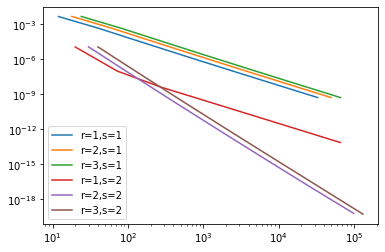

In [31]:
conv_table_start_time = time.time()
convergence_table = {}
for s in [1, 2]: # polynomial degree in space
    for r in [1, 2, 3]: # polynomial degree in time
        convergence_table[r, s] = {}
        slab_size = 1.
        n_x = 1
        for i in range(7): #8):
            slab_size *= 0.5
            n_x *= 2
        #for slab_size in [0.5**i*0.5 for i in range(6)]: #8)]:
            #for n_x in [2**i for i in range(6)]: #[10, 20, 40, 80, 160, 320]: # number of spatial elements in x-direction
                
            # start simulation
            cpu_start_time = time.time()
            print(f"CONFIG: s = {s}, r = {r}, slab_size = {slab_size}, n_x = {n_x}")
            
            ##############
            # SIMULATION #
            ##############
            L2_error = 0.

            ###########################################
            # 1. Create spatial finite element object #
            ###########################################
            space_mesh = IntervalMesh(n_x, 0., 1.) # \Omega = (0,1)
            space_V = FunctionSpace(space_mesh, 'CG', s)

            ####################
            # Spatial FE object:
            Space = SpaceFE(space_mesh, space_V)
            
            #################################################
            # 2. Start a time marching / time slabbing loop #
            #################################################
            start_time = 0.
            end_time = 0.5
            slabs = [(start_time, start_time+slab_size)]
            while slabs[-1][1] < end_time - 1e-8:
                slabs.append((slabs[-1][1], slabs[-1][1]+slab_size))
            #print(f"\nSlabs = {slabs}")

            # define analytical solution and rhs function
            def analytical_solution_1D(X):
                _x = X[:, 1]
                _t = X[:, 0]
                return np.sin(np.pi*_x)*(1.+_t)*np.exp(-0.5*_t)

            def rhs_function_1D(X):
                _x = X[:, 1]
                _t = X[:, 0]
                return np.sin(np.pi*_x)*np.exp(-0.5*_t)*(0.5+np.pi**2+(np.pi**2-0.5)*_t)

            analytical_solution = analytical_solution_1D
            rhs_function = rhs_function_1D
            
            # compute initial condition == analytical solution at t = start_time
            u0 = analytical_solution(cartesian_product_coords(np.array([[start_time]]), Space.dofs))

            # compute spatial boundary DoF indices
            bc = DirichletBC(Space.V, Constant(1.), lambda _, on_boundary: on_boundary)
            Space.boundary_dof_vector = np.zeros((Space.n_dofs,))
            for i in bc.get_boundary_values().keys():
                Space.boundary_dof_vector[i] = 1.
                
            #############################################
            # 2a) Create temporal finite element object #
            #############################################
            n_time = 2 # number of temporal elements
            time_mesh = IntervalMesh(n_time, slabs[0][0], slabs[0][1]) # Start time: slab[0], End time: slab[1] = slab[0]+slab_size
            time_V = FunctionSpace(time_mesh, 'DG', r)

            #####################
            # Temporal FE object:
            Time = TimeFE(time_mesh, time_V)
            total_time_n_dofs = Time.n_dofs * len(slabs)
            total_n_dofs = total_time_n_dofs * Space.n_dofs

            ####################################
            # 2b) Assemble space-time matrices #
            ####################################
            # NOTE: For linear PDEs this is just the kronecker product of temporal and spatial matrices
            system_matrix = scipy.sparse.kron(Time.matrix["derivative"], Space.matrix["mass"]) + scipy.sparse.kron(Time.matrix["mass"], Space.matrix["laplace"])
            mass_matrix = scipy.sparse.kron(Time.matrix["mass"], Space.matrix["mass"])

            space_time_coords = cartesian_product_coords(Time.dofs, Space.dofs)

            #################################################
            # 2d) Apply boundary conditions (system matrix) #
            #################################################
            dofs_at_boundary =  np.kron(np.ones((Time.dofs.shape[0],1)), Space.boundary_dof_vector.reshape(-1,1)).flatten()

            # apply space-time BC to system matrix
            system_matrix = system_matrix.multiply((1.-dofs_at_boundary).reshape(-1,1)) + scipy.sparse.diags(dofs_at_boundary)

            solve_factorized = scipy.sparse.linalg.factorized(system_matrix.tocsc())
            
            #####################
            # Time slabbing loop:
            for i, slab in enumerate(slabs):
                print(f"Solving on slab_{i} = Ω x ({round(slab[0],5)}, {round(slab[1],5)}) ...")

                #######################################
                # 2c) Assemble right hand side vector #
                #######################################
                # evaluate rhs function at the space-time Dofs and define the RHS as the space-time mass matrix times the projection of the RHS function
                rhs = mass_matrix.dot(rhs_function(space_time_coords))
                # add weak imposition of the initial condition to the right hand side
                rhs[:Space.n_dofs] += Space.matrix["mass"].dot(u0)

                #######################################
                # 2d) Apply boundary conditions (RHS) #
                #######################################
                # set the analytical solution as Dirichlet boundary conditions on the entire spatial boundary
                slab_analytical_solution = analytical_solution(space_time_coords)

                # apply space-time BC to right hand side
                rhs = rhs * (1. - dofs_at_boundary) + slab_analytical_solution * dofs_at_boundary

                ###########################
                # 2e) Solve linear system #
                ###########################
                # solve the linear system by using the factorization of the system matrix
                slab_solution = solve_factorized(rhs)

                ############################################
                # 2f) Compute error to analytical solution #
                ############################################
                # compute the error_vector between the projected analytical solution and the FEM solution
                slab_error = slab_analytical_solution - slab_solution
                # using the space-time mass matrix compute the L^2(I, L^2(Ω)) error on the slab
                L2_error += mass_matrix.dot(slab_error).dot(slab_error)

                # prepare next slab: get initial condition on next slab as final condition from this slab
                last_time_dof = Time.dofs.argmax()
                u0 = slab_solution[last_time_dof*Space.n_dofs:(last_time_dof+1)*Space.n_dofs]
                # shift the time in the space-time coordinates for the next slab
                space_time_coords[:, 0] += slab_size
                print("Done.\n")
                
            print("------------")
            print("| RESULTS: |")
            print("------------")
            print(f"#Temporal Dofs: {total_time_n_dofs}")
            print(f"#Spatial Dofs: {Space.n_dofs}")
            print(f"Space-time Dofs: {total_n_dofs}")
            print("L2 error:", L2_error)
            cpu_time = round(time.time() - cpu_start_time, 5)
            print(f"CPU Time: {cpu_time} s \n\n")
            convergence_table[r, s][Space.n_dofs, total_time_n_dofs] = {"dofs": total_n_dofs, "error": f"{L2_error:.3e}", "time": cpu_time}
                         
print(f"\n\nTime for creating convergence table: {round(time.time() - conv_table_start_time, 5)} s")
print("Convergence table:")
for (r, s) in convergence_table.keys():
    #x_index, y_index = set(), set()
    #for (x_ind, y_ind) in convergence_table[r, s].keys():
    #    x_index.add(x_ind)
    #    y_index.add(y_ind)
    #data = {y_ind : [convergence_table[r, s][x_ind, y_ind]["error"] for x_ind in sorted(list(x_index))] for y_ind in sorted(list(y_index))}
    #df = pd.DataFrame(data, index=sorted(list(x_index)))
    #print(df)
    print(f"r = {r}, s = {s}:", convergence_table[r, s])
    X = []
    Y = []
    for val in convergence_table[r, s].values():
        X.append(val["dofs"])
        Y.append(float(val["error"]))
    plt.plot(X, Y, label=f"r={r},s={s}")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()